In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install micrograd

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [3]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 -4*x +5

In [5]:
f(3.0)

20.0

In [6]:
xs=np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

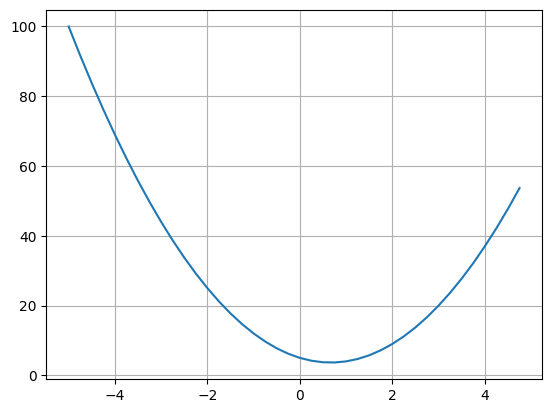

In [7]:
ys=f(xs)
plt.plot(xs,ys) 
plt.grid()

In [8]:
h=0.001
x=3.0
(f(x+h)-f(x))/h

14.00300000000243

In [9]:
def derivative(x,h=0.000001):
    return (f(x+h)-f(x))/h

In [10]:
derivative(2/3)

2.999378523327323e-06

In [11]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [12]:
h=0.000001
a=2.0
b=-3.0
c=10.0
d1=a*b+c  
a+=h
d2=a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)


d1 4.0
d2 3.9999969999999996
slope -3.000000000419334


In [286]:
class Value:
    def __init__(self,data,_children=(),_op='',label=' '):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self._backward=lambda :None
        self.label=label
        self.grad=0.0
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')
        
        def _backward():
            #self.grad=1.0*out.grad#bug
            #other.grad=1.0*out.grad#bug
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
        return out
    def __sub__(self,other):
        return self + (-other)
    def __rsub__(self,other):
        return other + (-self)
    def __neg__(self):
        return self*-1
    def __radd__(self,other):
        return self +other 
    def __truediv__(self,other):
        return self*other**-1
    def __rtruediv__(self,other):
        return other*self**-1
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
    def __rmul__(self,other):
        return self*other
    def __truediv__(self,other):
        return self*other**-1
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"only supporting int/float powers for now"
        out=Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad+=(other*self.data**(other-1))*out.grad
        out._backward=_backward
    def relu(self):
        out=Value(0 if self.data <0 else self.data, (self, ), 'ReLU')
        def _backward():
            self.grad+=(out.data>0)*out.grad
        out._backward=_backward
        return out
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward
        return out
    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2.0,label='f')
L=d*f;L.label="L"

In [287]:
# class Value:
#     """ stores a single scalar value and its gradient """

#     def __init__(self, data, _children=(), _op='',label=' '):
#         self.data = data
#         self.grad = 0
#         # internal variables used for autograd graph construction
#         self._op=_op
#         self._backward=lambda :None
#         self.label=label
#         self._prev = set(_children)
#         self._op = _op # the op that produced this node, for graphviz / debugging / etc

#     def __add__(self, other):
#         other = other if isinstance(other, Value) else Value(other)
#         out = Value(self.data + other.data, (self, other), '+')

#         def _backward():
#             self.grad += out.grad
#             other.grad += out.grad
#         out._backward = _backward

#         return out
#     def tanh(self):
#         x=self.data
#         t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
#         out=Value(t,(self,),'tanh')
#         def _backward():
#             self.grad+=(1-t**2)*out.grad
#         out._backward=_backward
#         return out
#     def __mul__(self, other):
#         other = other if isinstance(other, Value) else Value(other)
#         out = Value(self.data * other.data, (self, other), '*')

#         def _backward():
#             self.grad += other.data * out.grad
#             other.grad += self.data * out.grad
#         out._backward = _backward

#         return out

#     def __pow__(self, other):
#         assert isinstance(other, (int, float)), "only supporting int/float powers for now"
#         out = Value(self.data**other, (self,), f'**{other}')

#         def _backward():
#             self.grad += (other * self.data**(other-1)) * out.grad
#         out._backward = _backward

#         return out

#     def relu(self):
#         out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

#         def _backward():
#             self.grad += (out.data > 0) * out.grad
#         out._backward = _backward

#         return out

#     def backward(self):

#         # topological order all of the children in the graph
#         topo = []
#         visited = set()
#         def build_topo(v):
#             if v not in visited:
#                 visited.add(v)
#                 for child in v._prev:
#                     build_topo(child)
#                 topo.append(v)
#         build_topo(self)

#         # go one variable at a time and apply the chain rule to get its gradient
#         self.grad = 1
#         for v in reversed(topo):
#             v._backward()

#     def __neg__(self): # -self
#         return self * -1

#     def __radd__(self, other): # other + self
#         return self + other

#     def __sub__(self, other): # self - other
#         return self + (-other)

#     def __rsub__(self, other): # other - self
#         return other + (-self)

#     def __rmul__(self, other): # other * self
#         return self * other

#     def __truediv__(self, other): # self / other
#         return self * other**-1

#     def __rtruediv__(self, other): # other / self
#         return other * self**-1

#     def __repr__(self):
#         return f"Value(data={self.data}, grad={self.grad})"

In [288]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [289]:
d._op

'+'

In [290]:
from graphviz import Digraph
def trace(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
def draw_dot(root):
    dot=Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes,edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid,label="{%s |data %.4f|grad %.4f}"%(n.label,n.data,n.grad),shape='record')
        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

In [291]:
trace(d)

({Value(data=-3.0),
  Value(data=-6.0),
  Value(data=10.0),
  Value(data=2.0),
  Value(data=4.0)},
 {(Value(data=-3.0), Value(data=-6.0)),
  (Value(data=-6.0), Value(data=4.0)),
  (Value(data=10.0), Value(data=4.0)),
  (Value(data=2.0), Value(data=-6.0))})

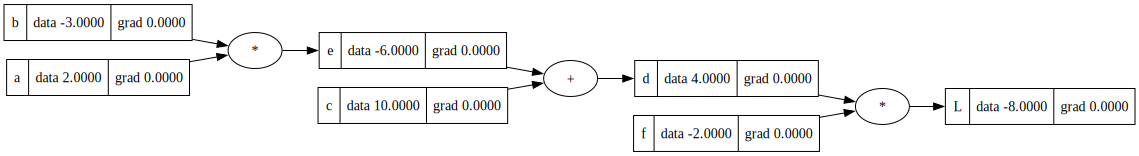

In [292]:
draw_dot(L)

L=d*f

dl/dd=? f

(f(x+h)-f(x))/h

((d+h)*f-d*f)/h

(d*f+h*f-d*f)/h

(h*f)/h

f

In [293]:
# L.grad=1.0
# f.grad=4.0
# d.grad=-2.0
# e.grad=-2.0
# c.grad=-2.0
# a.grad=6.0
# b.grad=-4.0

In [294]:
a.data+=0.001*a.grad
b.data+=0.001*b.grad
c.data+=0.001*c.grad
f.data+=0.001*f.grad

e=a*b
d=e+c
L=d*f
print(L.data)

-8.0


In [295]:
def lol():
    h=0.001
    a=Value(2.0,label='a')
    b=Value(-3.0,label='b')
    c=Value(10.0,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0,label='f')
    L=d*f;L.label="L"
    L1=L.data

    a=Value(2.0,label='a')
    b=Value(-3.0+h,label='b')
    c=Value(10.0,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0,label='f')
    L=d*f;L.label="L"
    L2=L.data
    print((L2-L1)/h)
lol()    

-3.9999999999995595


dL/dc=(dd/dc)*(dL/dd)

dd/dc=1

dL/dd=-2.0
dL/dc=-2
dl/de=dd/de*dL/dd=-2.0
dd/de=1


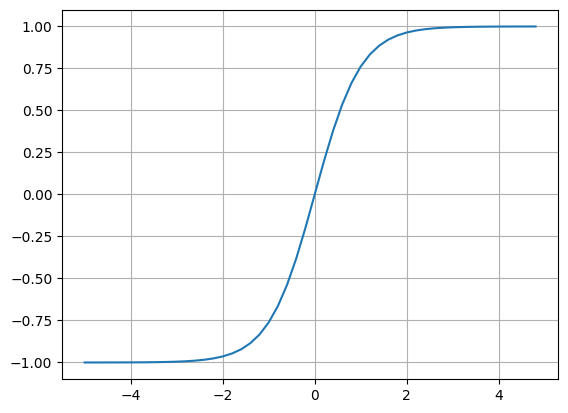

In [296]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid();

In [297]:
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
b=Value(6.88137353 ,label='b')
x1w1=x1*w1;x1w1.label='x1w1'
x2w2=x2*w2;x2w2.label='x2w2'
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1w1x2w2'
n=x1w1x2w2 +b;n.label='n'
func=n.tanh();func.label='o'

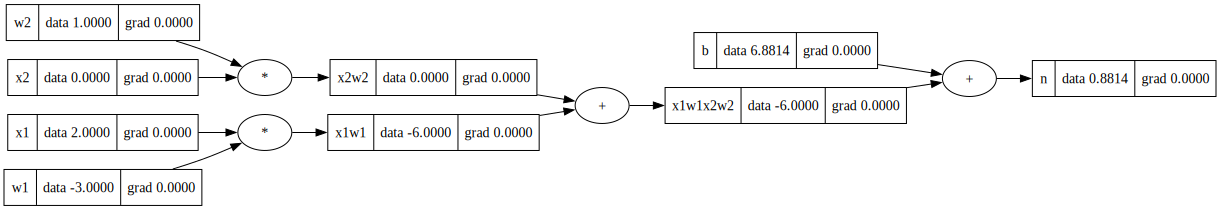

In [298]:
draw_dot(n)

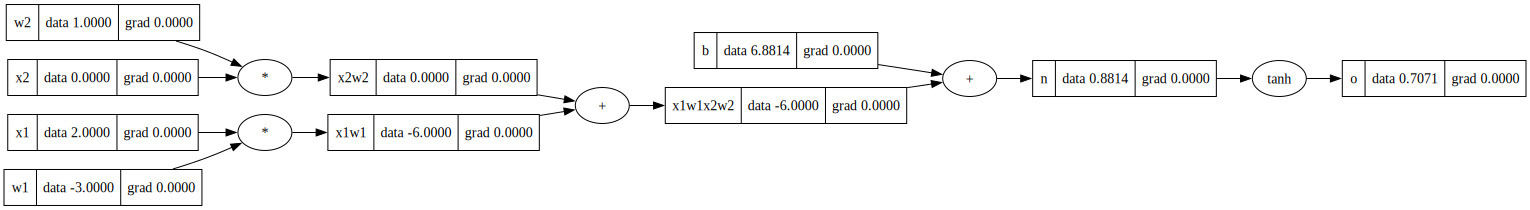

In [299]:
draw_dot(func)

In [300]:
# func.grad=1.0
# n.grad=0.5
# x1w1x2w2.grad=0.5
# b.grad=0.5
# x1w1.grad=0.5
# x2w2.grad=0.5
# x2.grad=0.5
# w2.grad=0.0
# x1.grad=-1.5
# w1.grad=1.0

# func.grad=0.0
n.grad=0.0
x1w1x2w2.grad=0.0
b.grad=0.0
x1w1.grad=0.0
x2w2.grad=0.0
x2.grad=0.0
w2.grad=0.0
x1.grad=0.0
w1.grad=0.0

o=tanh(n)
do/dn=1-tanh(n)**2
=1-0.7071**2
=0.4999

In [301]:
func.grad=1.0

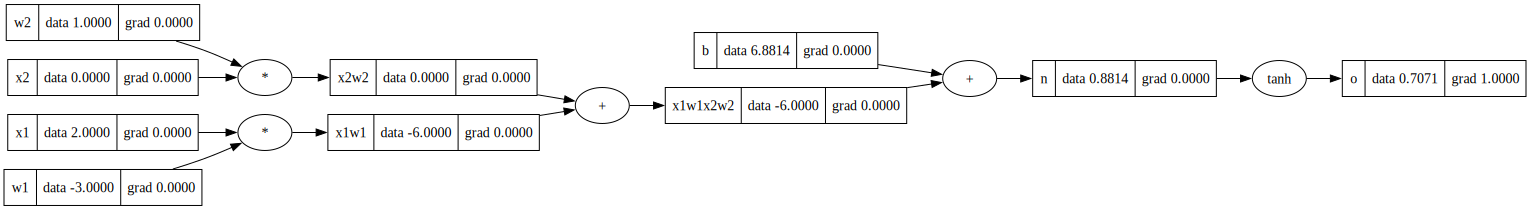

In [302]:
draw_dot(func)

In [303]:
func.backward()

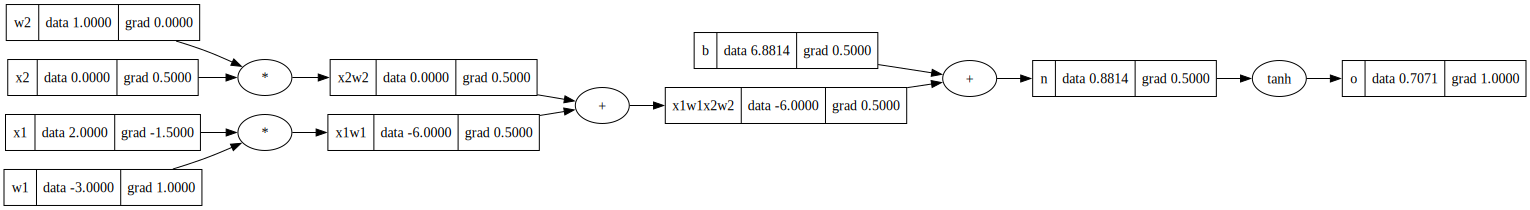

In [304]:
draw_dot(func)

In [305]:
n._backward()

In [306]:
b._backward()

In [307]:
x1w1x2w2._backward()

In [308]:
x2w2._backward()
x1w1._backward()

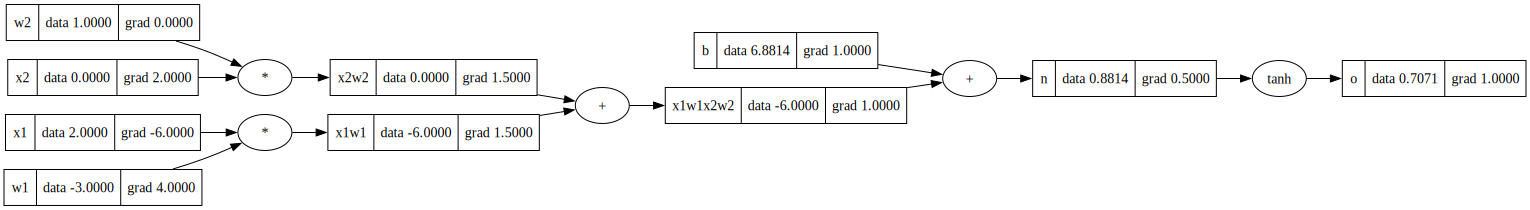

In [309]:
draw_dot(func)

In [310]:
topo=[]
visited=set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(func)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.88137353),
 Value(data=0.8813735300000003),
 Value(data=0.707106752676775)]

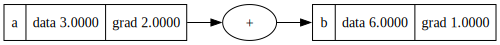

In [311]:
a=Value(3.0,label='a')
b=a+a;b.label='b'
b.backward()
draw_dot(b)

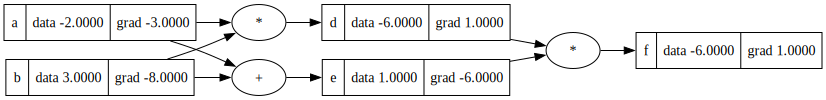

In [312]:
a=Value(-2.0,label='a')
b=Value(3.0,label='b')
d=a*b;d.label='d'
e=a+b;e.label='e'
f=d*e;f.label='f'
f.backward()
draw_dot(f)

In [313]:
import torch
x1=torch.Tensor([2.0]).double()   ;x1.requires_grad=True
x2=torch.Tensor([0.0]).double()   ;x2.requires_grad=True
w1=torch.Tensor([-3.0]).double()  ;w1.requires_grad=True
w2=torch.Tensor([1.0]).double()   ;w2.requires_grad=True
b=torch.Tensor([6.8813735870]).double()  ;b.requires_grad=True
n=x1*w1 + x2*w2 +b
o=torch.tanh(n)

print(o.data.item())
o.backward()
print('----')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [314]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [315]:
# import random
# class Neuron:
  
#   def __init__(self, nin):
#     self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
#     self.b = Value(random.uniform(-1,1))
  
#   def __call__(self, x):
#     # w * x + b
#     act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
#     out = act.tanh()
#     return out
# class Layer:
#     def __init__(self,nin,nout):
#         self.neurons=[Neuron(nin) for _ in range(nout)]
#     def __call__(self,x):
#         outs=[n(x) for n in self.neurons]
#         return outs[0] if len(outs) == 1 else outs
# class MLP:
#   def __init__(self,nin,nouts):
#     sz=[nin]+nouts
#     self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
#   def __call__(self,x):
#     for layer in self.layers:
#       x=layer(x)
#     return x

# x=[2.0,3.0]
# n=Layer(2,3)
# n(x)
# X=[2.0,3.0,-1.0]
# N=MLP(3,[4,4,1])
# N(X)

In [316]:
import random
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [317]:
n=MLP(3,[4,4,1])
xs=[[2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]]
ys=[1.0,-1.0,-1.0,1.0]

In [318]:
ypred=[n(x) for x in xs]
ypred

[Value(data=0.29351620906068465),
 Value(data=0.1544583018610447),
 Value(data=1.2060941988761296),
 Value(data=0.31401482655612284)]

In [329]:
import numpy as np
loss = ((np.array(ypred)-np.array(ys))**2).sum
print(loss)

<built-in method sum of numpy.ndarray object at 0x0000015F7B701410>


In [326]:
loss.backward()

AttributeError: 'builtin_function_or_method' object has no attribute 'backward'

In [336]:
n.layers[0].neurons[0].w[0].grad

0.0

In [337]:
draw_dot(loss)

AttributeError: 'builtin_function_or_method' object has no attribute '_prev'

In [338]:
n.parameters()

[Value(data=0.48036735760322213),
 Value(data=0.563791529906849),
 Value(data=-0.18343276682515164),
 Value(data=0.0),
 Value(data=0.33483332027581736),
 Value(data=0.49484894077197317),
 Value(data=-0.17887299592978545),
 Value(data=0.0),
 Value(data=-0.21755298478605),
 Value(data=0.8471821673999145),
 Value(data=-0.7045419744968482),
 Value(data=0.0),
 Value(data=-0.04049446381327626),
 Value(data=0.7853598052348836),
 Value(data=0.9702026788319447),
 Value(data=0.0),
 Value(data=-0.343210306906933),
 Value(data=0.04704685853189439),
 Value(data=-0.7818897734863339),
 Value(data=0.3337654522858693),
 Value(data=0.0),
 Value(data=-0.4635934104748034),
 Value(data=-0.35543268141900075),
 Value(data=-0.09887684088910276),
 Value(data=-0.8623808451970494),
 Value(data=0.0),
 Value(data=-0.27825761687657913),
 Value(data=0.14049098341782318),
 Value(data=-0.3237893738149018),
 Value(data=0.8108725703793658),
 Value(data=0.0),
 Value(data=0.33535189695456813),
 Value(data=0.06622618724138

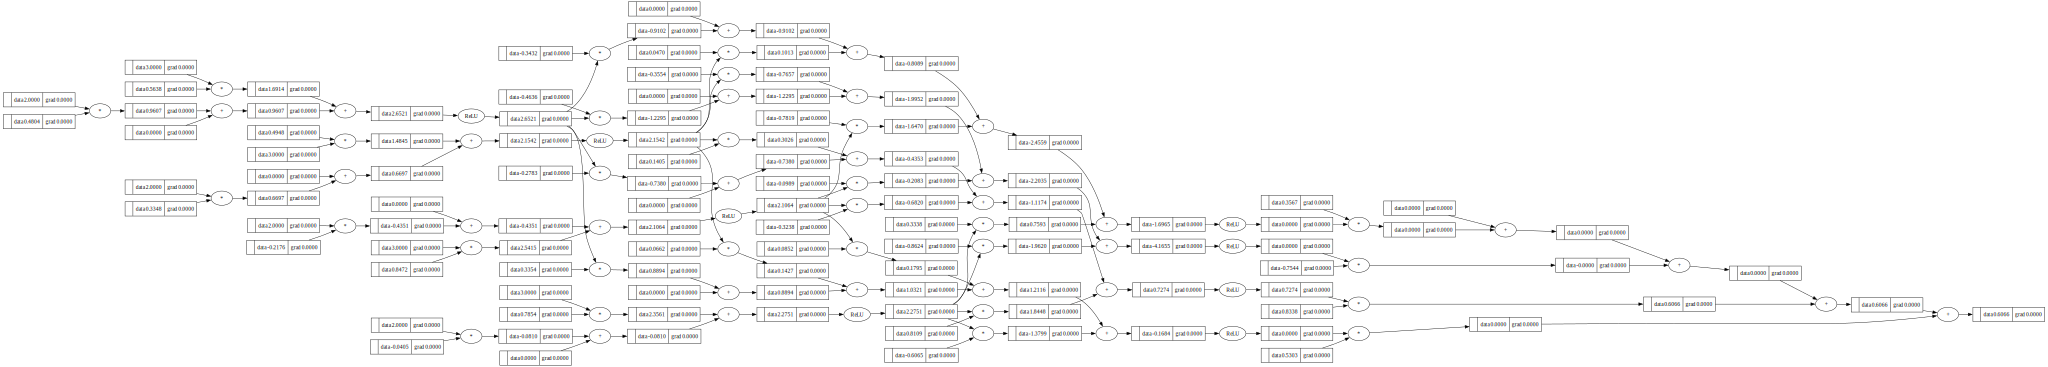

In [339]:
draw_dot(n(x))

In [346]:
for p in n.parameters():
    p.data+= -0.01*p.grad
    

In [347]:
n.layers[0].neurons[0].w[0].data

0.48036735760322213

In [348]:
ypred

[Value(data=0.29351620906068465),
 Value(data=0.1544583018610447),
 Value(data=1.2060941988761296),
 Value(data=0.31401482655612284)]

In [349]:
for k in range(20):
    ypred=[n(x) for x in xs]
    loss=sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
    for p in n.parameters():
        p.grad=0.0
    loss.backward()
    for p in n.parameters():
        p.data+=-0.05*p.grad
    print(k,loss.data)

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'